# Keras

## 【問題1】公式チュートリアルモデルを分担して実行

TensorFLowの公式チュートリアルモデルを分担して実行してください。


以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。

https://www.tensorflow.org/tutorials/

このチュートリアルでは、画像から猫または犬を分類する方法を示します。 tf.keras.Sequential モデルを使用して画像分類器を構築し、 tf.keras.preprocessing.image.ImageDataGenerator を使用してデータをロードします。このチュートリアルでは、以下のコンセプトにしたがって、実践的な経験と感覚を養います。

- tf.keras.preprocessing.image.ImageDataGenerator クラスを使用して**<span style="color: red; ">データ入力パイプライン</span>**を構築し、モデルで使用するディスク上のデータを効率的に処理します。
- 過学習（Overfitting） —過学習を識別および防止する方法。
- データ拡張（Data Augmentation） および**<span style="color: red; ">ドロップアウト（dropout）</span>**—データパイプラインおよび画像分類モデルに組み込むコンピュータービジョンタスクの過学習と戦うための重要なテクニック。

このチュートリアルは、基本的な機械学習のワークフローに従います。

1. データの調査及び理解
2. 入力パイプラインの構築
3. モデルの構築
4. モデルの学習
5. モデルのテスト
6. モデルの改善とプロセスの繰り返し

### パッケージのインポート

モデルの構築に必要な TensorFlow と Keras クラスをインポートします。

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
tf .__version__

'1.15.0'

### データの読み込み

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

データの内容を抽出した後、学習および検証セットのための適切な**<span style="color: red; ">ファイルパス</span>**で変数を設定します。

In [5]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [6]:
train_cats_dir = os.path.join(train_dir, 'cats') #  学習用の猫画像のディレクトリ
train_dogs_dir = os.path.join(train_dir, 'dogs')  # 学習用の犬画像のディレクトリ
validation_cats_dir = os.path.join(validation_dir, 'cats')  # 検証用の猫画像のディレクトリ
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # 検証用の犬画像のディレクトリ

### データの理解
学習および検証ディレクトリの中にある猫と犬の画像の数を見てみましょう:

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [8]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [9]:
batch_size = 128
epochs = 5
IMG_HEIGHT = 150
IMG_WIDTH = 150

### データの準備

モデルにデータを送る前に、画像を適切に前処理された浮動小数点テンソルにフォーマットします。

1. ディスクから画像を読み取ります。 


2. これらの画像のコンテンツを**<span style="color: red; ">デコード</span>**し、RGB値にしたがって適切なグリッド形式に変換します。


3. それらを**<span style="color: red; ">浮動小数点テンソル</span>**に変換します。 


4. ニューラルネットワークは小さな入力値を扱う方が適しているため、テンソルを0〜255の値から0〜1の値にリスケーリングします。


幸い、これらすべてのタスクは、 tf.keras によって提供される ImageDataGenerator クラスで実行できます。この ImageDataGenerator はディスクから画像を読み取り、適切なテンソルに前処理を行います。さらに、これらの画像をテンソルのバッチに変換する**<span style="color: red; ">ジェネレータ</span>**をセットアップします。これは、ネットワーク学習時に便利です。

In [10]:
train_image_generator = ImageDataGenerator(rescale=1./255) # 学習データのジェネレータ
validation_image_generator = ImageDataGenerator(rescale=1./255) # 検証データのジェネレータ

学習および検証画像のジェネレータを定義したのち、 `flow_from_directory` メソッドはディスクから画像をロードし、リスケーリングを適用し、画像を必要な大きさにリサイズします。

In [11]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [12]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### 学習用画像の可視化

学習用のジェネレータから**<span style="color: red; ">画像バッチ</span>**を抽出して可視化します。（この例では32個の画像を抽出し、そのうち5つを `matplotlib` で描画します。）

In [13]:
sample_training_images, _ = next(train_data_gen)

`next` 関数はデータセットからバッチを返します。 `next` 関数の返り値は `（x_train、y_train）` の形式で、 `x_train` は学習用の特徴量、 `y_train` はそのラベルです。ラベルを破棄して、学習用画像の可視化のみを行います。

In [14]:
# この関数は、1行5列のグリッド形式で画像をプロットし、画像は各列に配置されます。
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

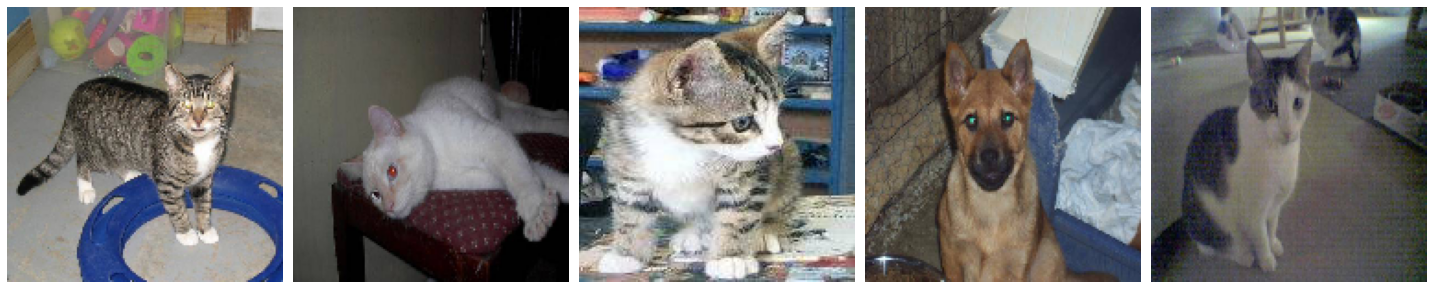

In [15]:
plotImages(sample_training_images[:5])

### モデルの構築

モデルはmax pooling層を伴う3つの畳み込みブロックからなります。さらに `relu` 活性化関数によるアクティベーションを伴う512ユニットの全結合層があります。モデルは、シグモイド活性化関数による2値分類に基づいてクラスに属する確率を出力します。

In [16]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### モデルのコンパイル
このチュートリアルでは、 *ADAM* オプティマイザーと *binary cross entropy* 損失関数を選択します。各学習エポックの学習と検証の精度を表示するために、`metrics` 引数を渡します。

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


すべてのネットワークのレイヤーを見るには、モデルの`summary`メソッドを利用します:

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

### モデルの学習

`ImageDataGenerator`クラスの`fit_generator`メソッドを使用して、ネットワークを学習します。

In [19]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/5
15/15 [==============================] - 16s 1s/step - loss: 1.1129 - acc: 0.5379 - val_loss: 0.6913 - val_acc: 0.5234
Epoch 2/5
15/15 [==============================] - 15s 1s/step - loss: 0.6835 - acc: 0.5588 - val_loss: 0.6663 - val_acc: 0.6317
Epoch 3/5
15/15 [==============================] - 14s 949ms/step - loss: 0.6489 - acc: 0.6303 - val_loss: 0.6395 - val_acc: 0.6529
Epoch 4/5
15/15 [==============================] - 14s 936ms/step - loss: 0.5904 - acc: 0.7014 - val_loss: 0.6272 - val_acc: 0.6518
Epoch 5/5
15/15 [==============================] - 14s 949ms/step - loss: 0.5345 - acc: 0.7417 - val_loss: 0.6311 - val_acc: 0.6685


### 学習結果の可視化

Text(0.5, 1.0, 'Training and Validation Accuracy')

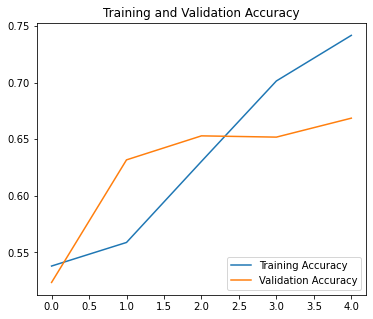

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

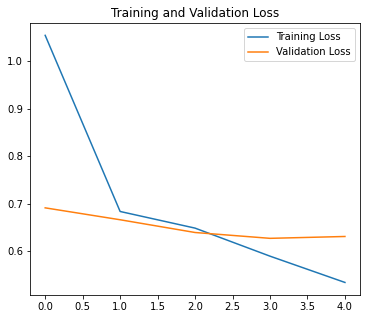

In [21]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**明らかな過学習が起きている。。。**

学習プロセスにおいて過学習に対抗する手段はいくつかあります。このチュートリアルでは、**データ拡張（data Augmentation）**を使用し、さらにモデルに**ドロップアウト（dropout）**を追加します。

## データ拡張

過学習は一般に、学習サンプルが少ない場合に発生します。この問題を解決する方法の1つは、十分な数の学習サンプルが含まれるようにデータセットを拡張することです。データ拡張は、既存の学習サンプルに対してランダムな変換を行い、データセットとして利用できそうな画像を生成するアプローチをとります。このデータ拡張の目的は、学習中にモデルがまったくおなじ画像を2回利用しないようにすることです。これによってモデルをデータのより多くの特徴を利用し、より汎化することができます。

`tf.keras` においては、このデータ拡張を `ImageDataGenerator` クラスを使用して実装します。データセットに対するさまざまな変換を指定することによって、学習プロセス中にそれが適用されます。

### 水平反転の適用

このデータ拡張を適用するためには、 `ImageDataGenerator` クラスの引数として `horizontal_flip` を渡し、 `True`を設定します。

In [22]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [23]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


学習サンプルから1つのサンプル画像を取得する作業を5回繰り返して、おなじ画像に5回データ拡張が適用されるようにします。

In [24]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

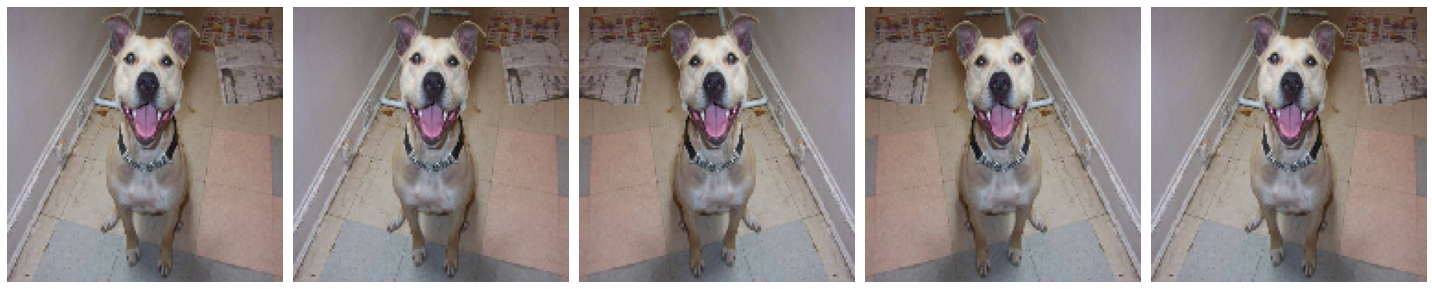

In [25]:
# 上で学習用画像の可視化のために定義、使用されたおなじカスタムプロット関数を再利用する
plotImages(augmented_images)

### 画像のランダムな回転

回転のデータ拡張を利用して学習用サンプルをランダムに左右45度の範囲で回転させてみましょう。

In [26]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [27]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


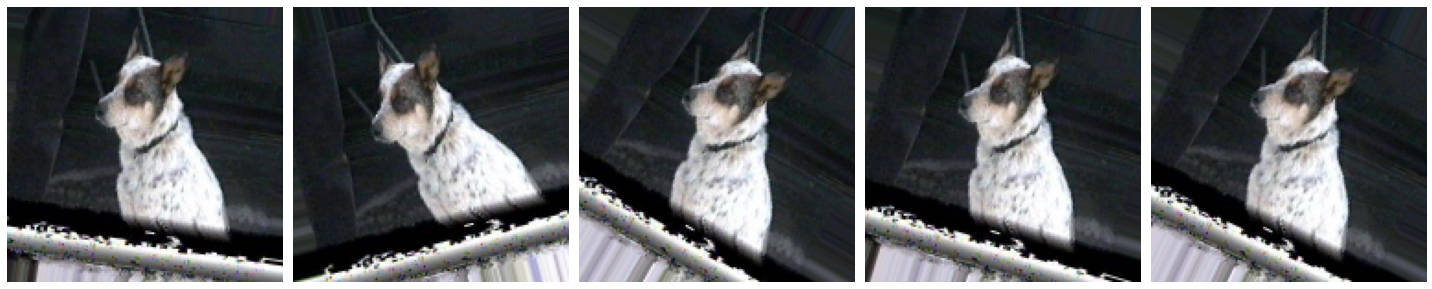

In [28]:
plotImages(augmented_images)

### ズームによるデータ拡張の適用

データセットにズームによるデータ拡張を適用して、画像をランダムに最大50％拡大します。

In [29]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

In [30]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


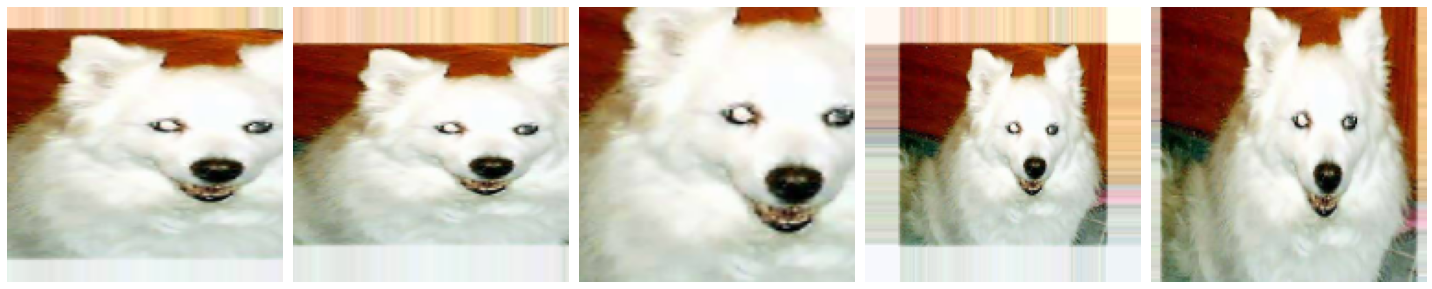

In [31]:
plotImages(augmented_images)

### すべてのデータ拡張を同時に利用する

ここまでで紹介したすべてのデータ拡張機能を適用します。

ここでは、学習用画像に対して、リスケール、45度の回転、幅シフト、高さシフト、水平反転、ズームを適用しました。

In [32]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [33]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


これらのデータ拡張がデータセットにランダムに適用されたときに、一つの画像に対して5回の個別の適用を行った際にそれぞれどのように見えるかを可視化します。

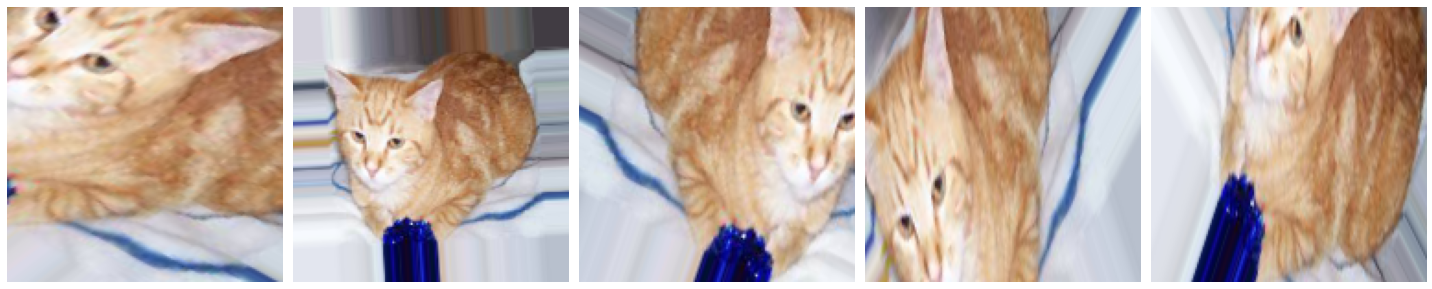

In [34]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 検証データジェネレータの構築

一般に、データ拡張は学習サンプルのみに適用します。今回は、 `ImageDataGenerator` を使用して検証画像に対してリスケールのみを実施し、バッチに変換します。

In [35]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [36]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


### ドロップアウト

過学習を避けるもう一つの方法は、ネットワークに**ドロップアウト**を導入することです。これは、ネットワークにおいて重みを小さくする正則化の方式で、これによって重みの値の分布がより規則的になり、少ない学習データに対する過学習を減らすことができます。ドロップアウトはこのチュートリアルで利用される正則化手法の一つです。

ドロップアウトをレイヤーに適用すると、学習プロセス中に適用されたレイヤーのうちランダムに出力ユニットをドロップアウト（ゼロに設定）します。ドロップアウトは、入力値として0.1、0.2、0.4といった形式の小数をとります。これは、適用されたレイヤーからランダムに出力単位の10％、20％、または40％をドロップアウトすることを意味します。

特定のレイヤーに0.1ドロップアウトを適用すると、各学習エポックにおいて出力ユニットの10％がランダムに0にされます。

この新しいドロップアウト機能を使用したネットワークアーキテクチャを作成し、異なる畳み込みレイヤーや全接続レイヤーに適用してみましょう。

### ドロップアウトを追加した新しいネットワークの構築

ここでは、ドロップアウトを最初と最後の max pool 層に適用します。ドロップアウトを適用すると、各学習エポック中にニューロンの20％がランダムにゼロに設定されます。これにより、学習データセットに対する過学習を避けることができます。

In [37]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

### ドロップアウト導入後のモデルのコンパイル

In [38]:
model_new.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

### 再学習

In [39]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/5
15/15 [==============================] - 20s 1s/step - loss: 1.0791 - acc: 0.4808 - val_loss: 0.6929 - val_acc: 0.5089
Epoch 2/5
15/15 [==============================] - 19s 1s/step - loss: 0.6931 - acc: 0.4882 - val_loss: 0.6921 - val_acc: 0.5089
Epoch 3/5
15/15 [==============================] - 19s 1s/step - loss: 0.6929 - acc: 0.4931 - val_loss: 0.6826 - val_acc: 0.5123
Epoch 4/5
15/15 [==============================] - 19s 1s/step - loss: 0.6823 - acc: 0.5318 - val_loss: 0.6572 - val_acc: 0.5279
Epoch 5/5
15/15 [==============================] - 18s 1s/step - loss: 0.6697 - acc: 0.5614 - val_loss: 0.6574 - val_acc: 0.5301


Text(0.5, 1.0, 'Training and Validation Accuracy')

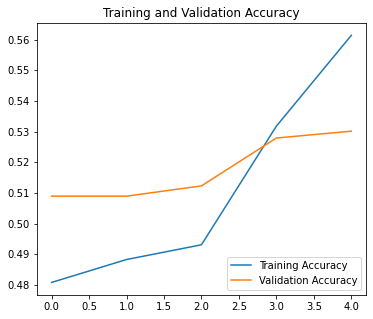

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

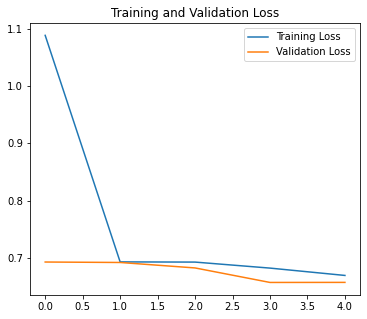

In [41]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 異なるフレームワークへの書き換え

「ディープラーニングフレームワーク1」で作成した4種類のデータセットを扱うTensorFLowのコードを異なるフレームワークに変更していきます。


- Iris（Iris-versicolorとIris-virginicaのみの2値分類）
- Iris（3種類全ての目的変数を使用して多値分類）
- House Prices
- MNIST

### Kerasへの書き換え

KerasはTensorFLowに含まれるtf.kerasモジュールを使用してください。


KerasにはSequentialモデルかFunctional APIかなど書き方に種類がありますが、これは指定しません。

### 【問題3】Iris（2値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する2値分類をKerasに書き換えてください。

In [42]:
df = pd.read_csv("Iris.csv")

# データフレームから条件を抽出する
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df.loc[:, ["Species"]]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]

# 特徴量を正規化する
from sklearn import preprocessing
X = preprocessing.scale(X)

# ラベルを数値に変換する（One Hot Encodingでダミー変数化する）
from pandas import get_dummies
y = get_dummies(y)
# from keras.utils import np_utils
# y = np_utils.to_categorical(y) 

# 配列に変換する
X= np.array(X)
y = np.array(y)

# trainとtestに分割する
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [43]:
# 関数を定義する
from keras.models import Sequential
from keras.layers.core import Dense, Activation

def create_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(4,), activation="relu")) #入力層（4ノード）、隠れ層（64ノード）
    model.add(Dense(2, activation="softmax")) # 出力層（2ノード）

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

Using TensorFlow backend.


In [44]:
#モデルの中身確認
model = create_model()
model.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 450
Trainable params: 450
Non-trainable params: 0
_________________________________________________________________


In [45]:
# 学習
history = model.fit(X_train, y_train, epochs=20, batch_size=5, validation_split=0.2, verbose=0)

# lossとaccuracyを表示する
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("loss：{:.2f}".format(loss))
print("accuracy：{:.2f}".format(accuracy))









loss：0.14
accuracy：0.95


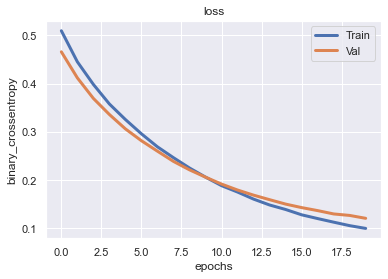

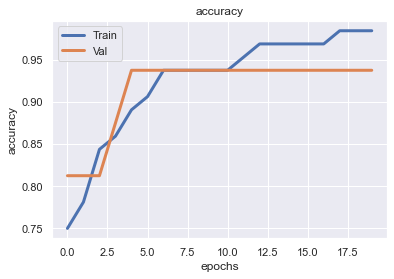

In [47]:
# 可視化
sns.set()
plt.plot(history.history["loss"], linewidth=3.0)
plt.plot(history.history["val_loss"], linewidth=3.0)
plt.title("loss")
plt.ylabel("binary_crossentropy")
plt.xlabel("epochs")
plt.legend(["Train", "Val"], loc="upper right")
plt.show()

plt.plot(history.history["acc"], linewidth=3.0)
plt.plot(history.history["val_acc"], linewidth=3.0)
plt.title("accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

### 【問題4】Iris（多値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する3値分類をKerasに書き換えてください。

In [48]:
# データセットを読み込む
df = pd.read_csv("Iris.csv")

# データフレームから条件を抽出する
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]

# 特徴量を正規化する
X = preprocessing.scale(X)

# ラベルを数値に変換する（One Hot Encodingでダミー変数化する）
y = get_dummies(y)
# from keras.utils import np_utils
# y = np_utils.to_categorical(y) 

# 配列に変換する
X= np.array(X)
y = np.array(y)

# trainとtestに分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [49]:
# 関数を定義する
def create_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(4,), activation="relu")) # 入力層（4ノード）、隠れ層（64ノード）
    model.add(Dense(3, activation="softmax")) # 出力層（3ノード）

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [50]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 195       
Total params: 515
Trainable params: 515
Non-trainable params: 0
_________________________________________________________________


In [51]:
# 学習
history = model.fit(X_train, y_train, epochs=30, batch_size=5, validation_split=0.2, verbose=0)

# lossとaccuracyを表示する
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("loss：{:.2f}".format(loss))
print("accuracy：{:.2f}".format(accuracy))

loss：0.22
accuracy：0.93


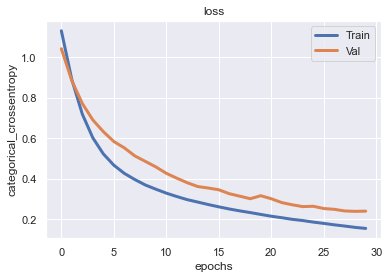

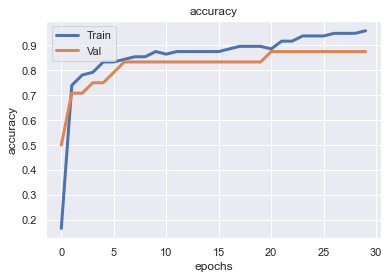

In [52]:
# 可視化
plt.plot(history.history["loss"], linewidth=3.0)
plt.plot(history.history["val_loss"], linewidth=3.0)
plt.title("loss")
plt.ylabel("categorical_crossentropy")
plt.xlabel("epochs")
plt.legend(["Train", "Val"], loc="upper right")
plt.show()

plt.plot(history.history["acc"], linewidth=3.0)
plt.plot(history.history["val_acc"], linewidth=3.0)
plt.title("accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

### 【問題5】House PricesをKerasで学習
TensorFlowによるHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [55]:
# データセットを読み込む
df = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")

# データフレームから「GrLivArea」と「YearBuilt」を抜き出して配列に変換する
X = df.loc[:,["GrLivArea","YearBuilt"]].values
# データフレームから「SalePrice」を抜き出して、配列に変換する
y = df.loc[:,["SalePrice"]].values

# trainとtestに分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 特徴量を標準化する
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [56]:
# 関数を定義する
def create_model():
    model = Sequential()
    model.add(Dense(200, input_shape=(X_train.shape[1], ), activation="relu")) # 隠れ層1（200ノード）
    model.add(Dense(100, activation="relu")) # 隠れ層2（100ノード）
    model.add(Dense(1, activation="relu")) # 出力層（1ノード）

    model.compile(optimizer="adam", loss="mean_squared_error", metrics =["mae"])
    return model

In [57]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 200)               600       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_________________________________________________________________


In [58]:
# 学習
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=0)

# loss（MSE）を表示
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("loss（MSE）：{:.2f}".format(loss))


loss（MSE）：2956851010.63


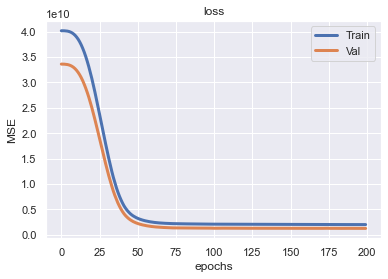

In [59]:
# 可視化
plt.plot(history.history["loss"], linewidth=3.0)
plt.plot(history.history["val_loss"], linewidth=3.0)
plt.title("loss")
plt.ylabel("MSE")
plt.xlabel("epochs")
plt.legend(["Train", "Val"], loc="upper right")
plt.show()

### 【問題6】MNISTをKerasで学習
TensorFlowによるMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [60]:
# mnistのデータセットを読み込む
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# データセットの下準備を行う
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

print(X_train.shape)

(60000, 28, 28, 1)


In [61]:
# OneHotEncoderのサンプルコードを実行する
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

# テストデータもone-hot表現に変換する
y_test_one_hot = enc.fit_transform(y_test[:, np.newaxis])
print(y_test_one_hot.shape)

(60000,)
(60000, 10)
float64
(10000, 10)


In [62]:
# 関数を定義する
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1))) # 隠れ層1（32ノード）
    model.add(MaxPooling2D((2, 2))) # プーリング層
    model.add(Flatten()) # 平滑化層
    model.add(Dense(64, activation='relu')) # 隠れ層2（64ノード）
    model.add(Dropout(0.5)) # ドロップアウト層
    model.add(Dense(10, activation='softmax')) # 出力層（10ノード）
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics =["accuracy"])
    return model

In [63]:
model = create_model()
model.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                346176    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 347,146
Tra

In [64]:
# 学習
history = model.fit(X_train, y_train_one_hot, epochs=20, batch_size=200, validation_split=0.2, verbose=0)

# lossとaccuracyを表示する
loss, accuracy = model.evaluate(X_test, y_test_one_hot, verbose=0)
print("loss：{:.2f}".format(loss))
print("accuracy：{:.2f}".format(accuracy))

loss：0.05
accuracy：0.99


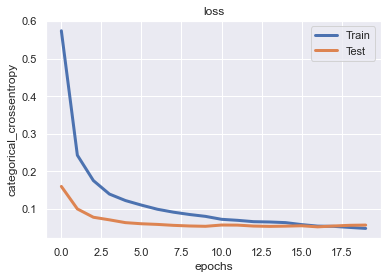

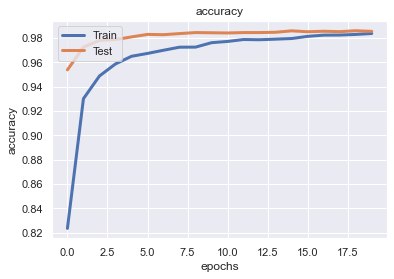

In [65]:
# 可視化
plt.plot(history.history["loss"], linewidth=3.0)
plt.plot(history.history["val_loss"], linewidth=3.0)
plt.title("loss")
plt.ylabel("categorical_crossentropy")
plt.xlabel("epochs")
plt.legend(["Train", "Test"], loc="upper right")
plt.show()

plt.plot(history.history["acc"], linewidth=3.0)
plt.plot(history.history["val_acc"], linewidth=3.0)
plt.title("accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

### 【問題7】（アドバンス課題）PyTorchへの書き換え
4種類の問題をPyTorchに書き換えてください。

In [67]:
!pip install torch torchvision torchaudio

#### Iris（多値分類）

In [68]:
# データセットを読み込む
df = pd.read_csv("Iris.csv")

#　データフレームから条件を抽出し、ラベルを数値化する
y = np.array(df["Species"].astype("category").cat.codes).astype(float)
X = np.array(df.iloc[:, :4])

# 特徴量を正規化する
X = preprocessing.scale(X)

# trainとtestに分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割する
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# tensor型に変換する
import torch
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
X_val = torch.Tensor(X_val)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
y_val = torch.LongTensor(y_val)

# DataLoader化する
# train = torch.utils.data.TensorDataset(X_train, y_train)
# train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)

In [69]:
# クラスを作成する
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.manual_seed(0)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 64) # 入力層（4）から隠れ層（64）へ
        self.fc2 = nn.Linear(64, 3) # 隠れ層（64）から出力層（3）へ
        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [70]:
# インスタンスを生成
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)


In [72]:
#学習する
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 50
train_loss = []
train_acc = []
val_loss = []
val_acc = []

model.train()
for epoch in range(epochs):
    data, target = Variable(X_train), Variable(y_train)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    train_loss.append(loss.data.item())
    loss.backward()
    optimizer.step()
        
    prediction = output.data.max(1)[1] 
    accuracy = prediction.eq(target.data).sum().numpy() / len(X_train)
    train_acc.append(accuracy)
    
    v_data, v_target = Variable(X_val), Variable(y_val)
    v_output = model(v_data)        
    v_loss = F.nll_loss(v_output, v_target)
    val_loss.append(v_loss.data.item())
    v_prediction = v_output.data.max(1)[1] 
    v_accuracy = v_prediction.eq(v_target.data).sum().numpy() / len(X_val)
    val_acc.append(v_accuracy)

    if epoch % 10 == 0:
        print('epoch：{}, loss：{:.4f}, val_loss：{:.4f}, score：{:.3f}, val_score：{:.3f}'.format(
            epoch, loss.data.item(), v_loss.data.item(), accuracy, v_accuracy))

t_data, t_target = Variable(X_test), Variable(y_test)
t_output = model(t_data)        
t_prediction = t_output.data.max(1)[1] 
t_accuracy = t_prediction.eq(t_target.data).sum().numpy() / len(X_test)
print("test_acc : {:.3f}".format(t_accuracy))

epoch：0, loss：1.3002, val_loss：1.0517, score：0.000, val_score：0.292
epoch：10, loss：0.3408, val_loss：0.3358, score：0.917, val_score：0.875
epoch：20, loss：0.1545, val_loss：0.1701, score：0.958, val_score：1.000
epoch：30, loss：0.0749, val_loss：0.1049, score：0.990, val_score：1.000
epoch：40, loss：0.0418, val_loss：0.0652, score：1.000, val_score：1.000
test_acc : 1.000


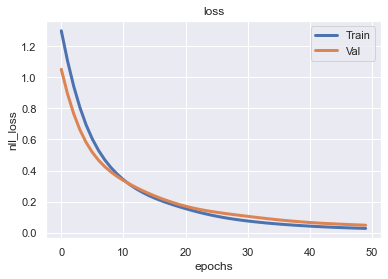

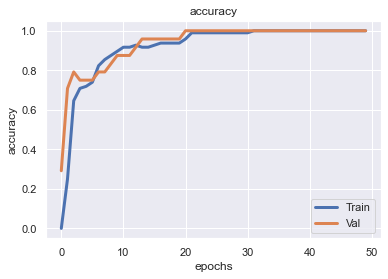

In [73]:
# 可視化
plt.plot(range(epochs), train_loss, label="Train", linewidth=3.0)
plt.plot(range(epochs), val_loss, label="Val", linewidth=3.0)
plt.legend()
plt.title("loss")
plt.xlabel("epochs")
plt.ylabel("nll_loss")
plt.legend(frameon=True)
plt.show()

plt.plot(range(epochs), train_acc, label="Train", linewidth=3.0)
plt.plot(range(epochs), val_acc, label="Val", linewidth=3.0)
plt.legend()
plt.title("accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(frameon=True)
plt.show()

#### House Prices

In [75]:
# データセットを読み込む
df = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")

# データフレームから「GrLivArea」と「YearBuilt」を抜き出して配列に変換する
X = df.loc[:,["GrLivArea","YearBuilt"]].values
# データフレームから「SalePrice」を抜き出して、配列に変換する
y = df.loc[:,["SalePrice"]].values

# trainとtestに分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 説明変数を標準化する
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# さらにtrainとvalに分割する
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# tensor型に変換する
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
X_val = torch.Tensor(X_val)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)
y_val = torch.Tensor(y_val)

# DataLoader化
# train = torch.utils.data.TensorDataset(X_train, y_train)
# train_loader = torch.utils.data.DataLoader(train, batch_size=50, shuffle=True)

In [76]:
# クラスを作成する
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 200) # 入力層（2）から隠れ層1（200）へ
        self.fc2 = nn.Linear(200, 100) # 隠れ層1（200）から隠れ層2（100）へ
        self.fc3 = nn.Linear(100, 1) # 隠れ層2（100）から出力層（1）へ
        
    def forward(self, X):
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        return X

In [77]:
# インスタンスを生成
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=2, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


In [78]:
# 学習する
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
epochs = 500
train_loss = []
val_loss = []

model.train()
for epoch in range(epochs):   
    data, target = Variable(X_train), Variable(y_train)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    train_loss.append(loss.data.item())
    loss.backward()
    optimizer.step()
    
    v_data, v_target = Variable(X_val), Variable(y_val)
    v_output = model(v_data)        
    v_loss = criterion(v_output, v_target)
    val_loss.append(v_loss.data.item())

    if epoch % 50 == 0:
        print("epoch：{}, loss（MSE）：{:.4f}, val_loss（MSE）：{:.4f}".format(
            epoch, loss.data.item(), v_loss.data.item()))

t_data, t_target = Variable(X_test), Variable(y_test)
t_output = model(t_data)
t_loss = criterion(t_output, t_target)
print("test_loss（MSE）：{:.4f}".format(t_loss.data.item()))

epoch：0, loss（MSE）：39276216320.0000, val_loss（MSE）：37141438464.0000
epoch：50, loss（MSE）：35651411968.0000, val_loss（MSE）：33242150912.0000
epoch：100, loss（MSE）：14149295104.0000, val_loss（MSE）：11518800896.0000
epoch：150, loss（MSE）：2140599424.0000, val_loss（MSE）：1562718336.0000
epoch：200, loss（MSE）：2104155392.0000, val_loss（MSE）：1574138880.0000
epoch：250, loss（MSE）：2104099712.0000, val_loss（MSE）：1578093824.0000
epoch：300, loss（MSE）：2104096128.0000, val_loss（MSE）：1577468928.0000
epoch：350, loss（MSE）：2104096256.0000, val_loss（MSE）：1577518080.0000
epoch：400, loss（MSE）：2104096256.0000, val_loss（MSE）：1577518208.0000
epoch：450, loss（MSE）：2104096384.0000, val_loss（MSE）：1577518208.0000
test_loss（MSE）：2948415744.0000


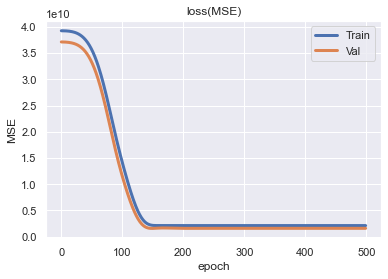

In [79]:
# 学習過程を可視化する
plt.figure()
plt.plot(range(epochs), train_loss, label="Train", linewidth=3.0)
plt.plot(range(epochs), val_loss, label="Val", linewidth=3.0)
plt.legend()
plt.title("loss(MSE)")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend(frameon=True)
plt.show()

#### MNIST

In [80]:
# mnistのデータセットを読み込む
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# データセットの下準備を行う
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_val.shape)

(48000, 1, 28, 28)
(12000, 1, 28, 28)


In [81]:
# OneHotEncoderのサンプルコードを実行する
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

# 検証データ、テストデータもone-hot表現に変換する
y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
print(y_val_one_hot.shape)
y_test_one_hot = enc.fit_transform(y_test[:, np.newaxis])
print(y_test_one_hot.shape)

(48000,)
(48000, 10)
float64
(12000, 10)
(10000, 10)


In [82]:
# tensor型に変換する
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
X_val = torch.Tensor(X_val)
y_train_one_hot = torch.Tensor(y_train_one_hot)
y_test_one_hot = torch.Tensor(y_test_one_hot)
y_val_one_hot = torch.Tensor(y_val_one_hot)

# DataLoader化
train = torch.utils.data.TensorDataset(X_train, y_train_one_hot)
train_loader = torch.utils.data.DataLoader(train, batch_size=1000, shuffle=True)

In [83]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 32, 3, 1) # 入力層から隠れ層1へ
        self.fc1 = nn.Linear(32*13*13, 64) # 隠れ層1から隠れ層2へ
        self.dropout = nn.Dropout(0.5) # ドロップアウト層
        self.fc2 = nn.Linear(64, 10) # 隠れ層2から出力層へ
        
    def forward(self, X):
        # X = X.view(-1, 28*28) # リサイズが必要な場合: (N, 1, 28, 28) --> (N, 784)
        X = F.relu(self.conv(X))
        X = F.max_pool2d(X, 2) # プーリング層
        X = torch.flatten(X, 1) # 平滑化層
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [84]:
# インスタンスを生成
model = Net()
print(model)

Net(
  (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=5408, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [85]:
# 学習
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 20
train_loss = []
train_acc = []
val_loss = []
val_acc = []

model.train()
for epoch in range(epochs):
    for _, train in enumerate(train_loader):
        X_train, y_train_one_hot = train 
        data, target = Variable(X_train), Variable(y_train_one_hot)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, torch.max(target, 1)[1])
        loss.backward()
        optimizer.step()

    train_loss.append(loss.data.item())
    prediction = output.data.max(1)[1]
    label = torch.max(y_train_one_hot,1)[1]
    accuracy = prediction.eq(label).sum().numpy() / len(X_train)
    train_acc.append(accuracy)

    v_data, v_target = Variable(X_val), Variable(y_val_one_hot)
    v_output = model(v_data)        
    v_loss = criterion(v_output, torch.max(v_target, 1)[1])
    val_loss.append(v_loss.data.item())
    v_prediction = v_output.data.max(1)[1] 
    v_label = torch.max(y_val_one_hot,1)[1]    
    v_accuracy = v_prediction.eq(v_label).sum().numpy() / len(X_val)
    val_acc.append(v_accuracy)

    if epoch % 3 == 0:
        print('epoch：{}, loss：{:.4f}, val_loss：{:.4f}, score：{:.3f}, val_score：{:.3f}'.format(
            epoch, loss.data.item(), v_loss.data.item(), accuracy, v_accuracy))

t_data, t_target = Variable(X_test), Variable(y_test_one_hot)
t_output = model(t_data)        
t_prediction = t_output.data.max(1)[1] 
t_label = torch.max(y_test_one_hot,1)[1]
t_accuracy = t_prediction.eq(t_label).sum().numpy() / len(X_test)
print("test_acc : {:.3f}".format(t_accuracy))

epoch：0, loss：0.3852, val_loss：0.2995, score：0.880, val_score：0.909
epoch：3, loss：0.1332, val_loss：0.1491, score：0.958, val_score：0.955
epoch：6, loss：0.1037, val_loss：0.1240, score：0.966, val_score：0.963
epoch：9, loss：0.0748, val_loss：0.1168, score：0.975, val_score：0.967
epoch：12, loss：0.0801, val_loss：0.1094, score：0.979, val_score：0.968
epoch：15, loss：0.0646, val_loss：0.1158, score：0.980, val_score：0.969
epoch：18, loss：0.0442, val_loss：0.1256, score：0.989, val_score：0.971
test_acc : 0.970


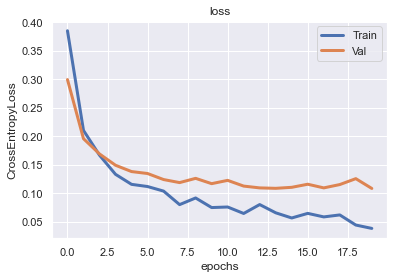

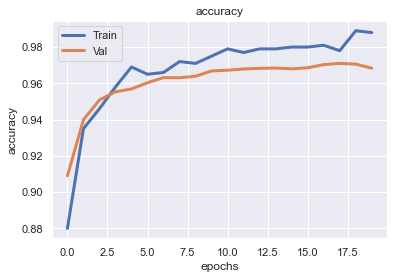

In [86]:
# 可視化
plt.plot(range(epochs), train_loss, label="Train", linewidth=3.0)
plt.plot(range(epochs), val_loss, label="Val", linewidth=3.0)
plt.legend()
plt.title("loss")
plt.xlabel("epochs")
plt.ylabel("CrossEntropyLoss")
plt.legend(frameon=True)
plt.show()

plt.plot(range(epochs), train_acc, label="Train", linewidth=3.0)
plt.plot(range(epochs), val_acc, label="Val", linewidth=3.0)
plt.legend()
plt.title("accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(frameon=True)
plt.show()